# ML Course Project: Data Analysis & Modeling




## Introduction
In this project, a number of data
mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

## Setup

1. Create new python environment for the project

- This is not necessary on Google Colab but a good practice on your local machine

2. Install the required packages

In [1]:
!pip install ucimlrepo

## Imports

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import cProfile

import itertools, collections
import numpy as np
import pandas as pd

from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import LabelEncoder
#libraries used for feature selection implementation, will be removed if not allowed to use
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
#library used for SMOTE implementation
from sklearn.neighbors import NearestNeighbors
#just for testing for now
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
from scipy.linalg import eigh
from sklearn.cluster import KMeans 
from sklearn.metrics import pairwise_distances
from scipy.sparse.linalg import eigsh
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import kneighbors_graph
import random

## Load Data

In [4]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets
# Create a MinMaxScaler object
scaler = MinMaxScaler()

X_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)

X

{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,fractal_dimension1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

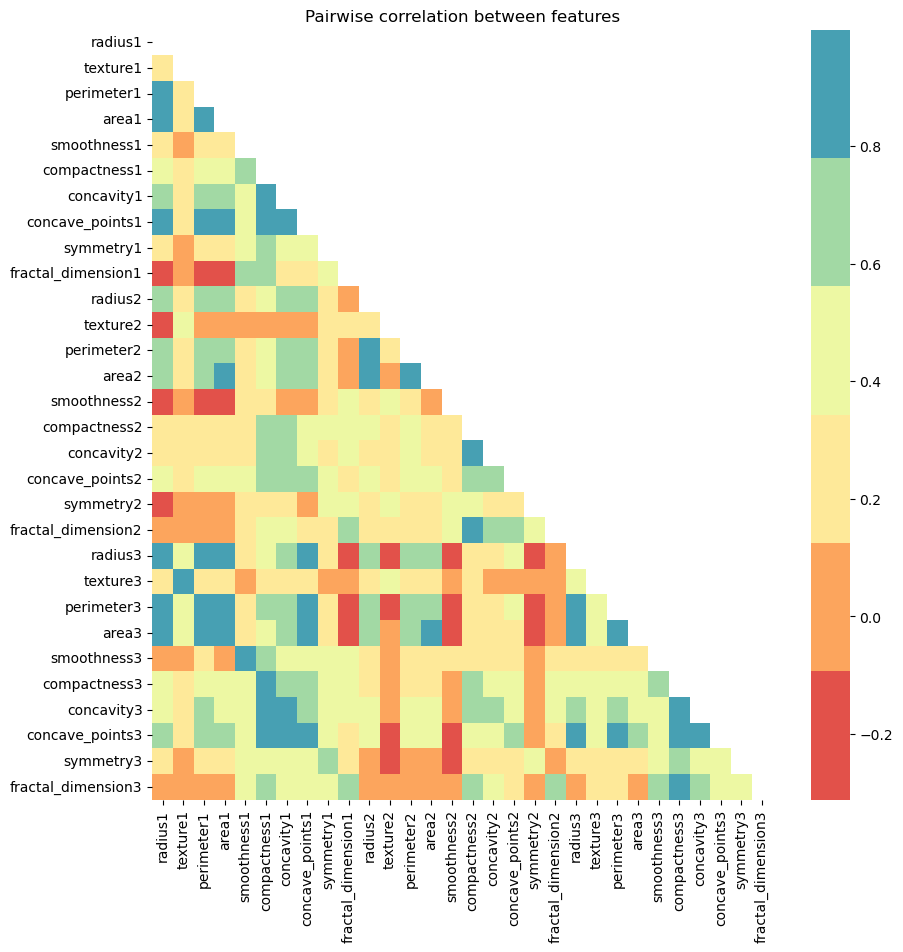

In [4]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class-wise counts

In [5]:
print(collections.Counter(y['Diagnosis']))

Counter({'B': 357, 'M': 212})


### Class-wise features distributions

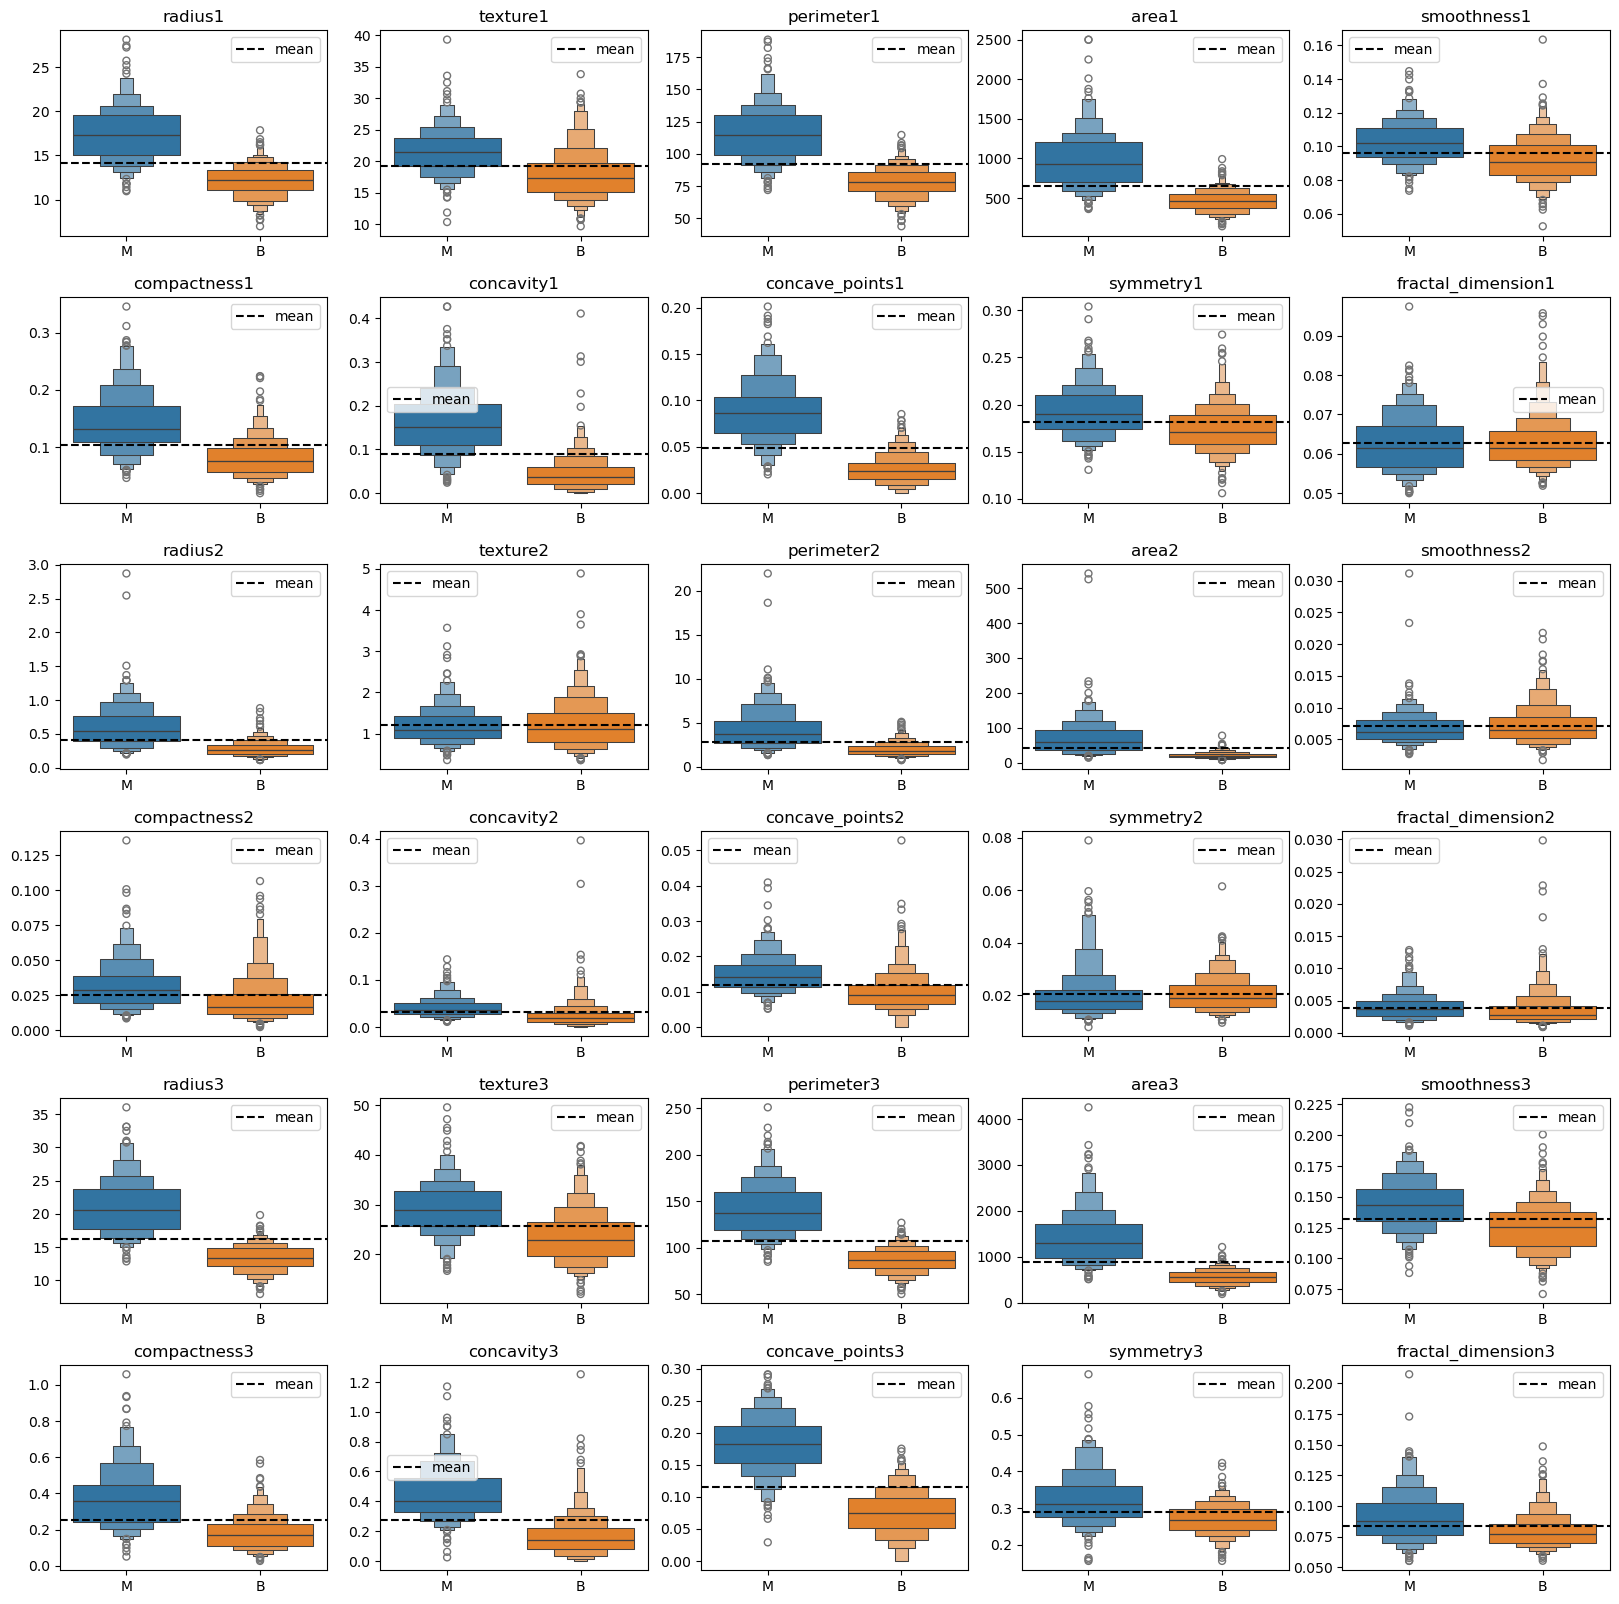

In [6]:
plt.figure(figsize=(20,20))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(6,5,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.ylabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

In [7]:
print(y)

    Diagnosis
0           M
1           M
2           M
3           M
4           M
..        ...
564         M
565         M
566         M
567         M
568         B

[569 rows x 1 columns]


In [8]:
print("Missing values in each column:")
#print(X.isna().sum())
#print (y.isna().sum())

# Check specifically in the features you are using
#print("\nMissing values in feature matrix (X):")
#print(pd.DataFrame(X).isna().sum())
#print(pd.DataFrame(y).isna().sum())

Missing values in each column:


In [9]:
y = y['Diagnosis'] 


y = y.map({'B': 0, 'M': 1})

# Phase 1 - Supervised Techniques

## Q1 - Implementing simple classifiers

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]


## Q1 - Implementing simple classifiers
I implemented two classes ` DecisionTreeClassifierCustom`, `NaiveBayesGaussian`  and a another function to evluate each classifier `evaluate_classifier(classifier_cls, X, y)` by passing the classifier and data as a parameters

**1. DecisionTreeClassifierCustom:** It build the decision tree with the help of some functions. The implementation uses Information Gain criterion. The information Gain is calculated based on entropy to decide how to split the nodes. Here is a breakdown of the code with explanation. 

* **`__init__(self, max_depth=None)`:**
    * Initializes the object with an optional `max_depth` parameter for the decision tree.
    * Stores the `max_depth` and initializes an empty `tree` attribute.

* **`fit(self, X, y)`:**
    * Concatenates features `X` and target labels `y` into a single data matrix.
    * Calls the recursive `_build_tree` function to build the decision tree using the data.

* **`_build_tree(self, data, depth)`:**
    * Recursively builds the decision tree:
        * Separates data into features and labels.
        * Checks for termination conditions:
            * No data points remaining (`num_samples == 0`).
            * Maximum depth reached (`max_depth` is not None and `depth` equals `max_depth`).
            * All data points belong to the same class (`np.unique(y).size == 1`).
        * Otherwise, finds the best feature and split value to separate the data.
        * Recursively builds sub-trees for left and right branches based on the split.
        * Returns a tuple containing the best feature, split value, and left/right sub-trees.

* **`_best_split(self, data)`:**
    * Finds the feature and split value that maximizes information gain for classification.
    * Calculates entropy for the entire dataset (`base_entropy`).
    * Iterates through all features and potential split values.
    * For each split, calculates the entropy for the left and right branches.
    * Calculates the information gain achieved by splitting on the current feature and value.
    * Updates the best feature, split value, and information gain if the current gain is higher.
    * Returns the best feature, split value, and information gain achieved.

* **`_entropy(self, y)`:**
    * Ensures `y` is numeric using `ensure_numeric_y` before calculating entropy.
    * Handles the case of an empty dataset (returns 0 entropy).
    * Calculates class probabilities from class counts.
    * Applies the formula for information entropy using logarithms (base 2).
    * Returns the calculated entropy.

* **`predict(self, X)`:**
    * Iterates through each data point in `X` and uses the built decision tree to predict the class label.
    * Calls the recursive `_predict` function on each data point and the tree structure.

* **`_predict(self, inputs, tree)`:**
    * Recursively traverses the decision tree based on the data point's features:
        * If the current node is a leaf (not a tuple), it represents the predicted class and is returned.
        * Otherwise, the node is a split point based on a feature.
        * Compares the data point's feature value with the split value.
        * Recursively calls `_predict` on the appropriate sub-tree (left or right) based on the comparison.


**2. `NaiveBayesGaussian`** is a class that implements a Naive Bayes classifier that models continuous features using Gaussian distributions.



* **`__init__(self)`:**
    * Initializes empty dictionaries for storing class labels (`classes`), class means (`mean`), class variances (`var`), and class priors (`priors`).

* **`fit(self, X, y)`:**
    * Ensures `y` is a 1-dimensional array (flattened if necessary).
    * Checks for consistent sample sizes between features and labels.
    * Stores unique class labels (`classes`).
    * For each class:
        * Filters data points belonging to the class.
        * Calculates the mean and variance of features for the class data.
        * Calculates the class prior probability (proportion of samples belonging to the class).

* **`predict(self, X)`:**
    * Uses the trained model to predict class labels for new data points in `X`.
    * Iterates through each data point and calls the private `_predict` function.

* **`_predict(self, x)`:**
    * Calculates the posterior probability for each class.
    * For each class:
        * Calculates the class prior probability (stored in `priors`).
        * Calculates the class conditional probability (product of individual feature probabilities using Gaussian distribution).
        * Combines prior and class conditional probabilities to get the posterior probability.
    * Returns the class label with the highest posterior probability.

* **`_probability(self, class_idx, x)`:**
    * Calculates the probability of a data point `x` belonging to a specific class

**3. `evaluate_classifier`**
This function provides a framework to assess the performance of a custom classifier using stratified 10-fold cross-validation

In [5]:
# [YOUR IMPLEMENTATION CODE HERE]

def ensure_numeric_y(y):
    # Ensure y is a NumPy array
    y = np.array(y)
    
    # If y is of object dtype, it might mean there are non-integer values
    if y.dtype == 'O':
        try:
            # Try converting it to integers directly
            y = y.astype(int)
        except ValueError:
            # If there's a conversion error, use Label Encoding
            label_encoder = LabelEncoder()
            y = label_encoder.fit_transform(y)
    return y

class DecisionTreeClassifierCustom:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree = None

    def fit(self, X, y):
        data = np.concatenate((X, y.reshape(-1, 1)), axis=1)
        self.tree = self._build_tree(data, 0)

    '''
    def _build_tree(self, data, depth):
        X, y = data[:, :-1], data[:, -1]
        num_samples, num_features = X.shape

        if num_samples == 0:
            return None
        
        if self.max_depth is not None and depth == self.max_depth:
            return np.bincount(y).argmax()

        if np.unique(y).size == 1:
            return y[0]

        best_feature, best_value, _ = self._best_split(data)
        if best_feature is None:
            return np.bincount(y).argmax()

        left_indices = (data[:, best_feature] < best_value)
        right_indices = ~left_indices
        left_tree = self._build_tree(data[left_indices], depth + 1)
        right_tree = self._build_tree(data[right_indices], depth + 1)
        return (best_feature, best_value, left_tree, right_tree)
    '''
    
    def _build_tree(self, data, depth):
        X, y = data[:, :-1], data[:, -1]
        num_samples, num_features = X.shape

        if num_samples == 0:
            return None

        if self.max_depth is not None and depth == self.max_depth:
            # Ensure y is integer before calling np.bincount
            return np.bincount(y.astype(int)).argmax()

        if np.unique(y).size == 1:
            return y[0]

        best_feature, best_value, _ = self._best_split(data)
        if best_feature is None:
            # Ensure y is integer before calling np.bincount
            return np.bincount(y.astype(int)).argmax()

        left_indices = (data[:, best_feature] < best_value)
        right_indices = ~left_indices
        left_tree = self._build_tree(data[left_indices], depth + 1)
        right_tree = self._build_tree(data[right_indices], depth + 1)
        return (best_feature, best_value, left_tree, right_tree)


    def _best_split(self, data):
        X, y = data[:, :-1], data[:, -1]
        num_samples, num_features = X.shape
        best_gain = -1
        best_feature = None
        best_value = None

        base_entropy = self._entropy(y)

        for feature in range(num_features):
            values = np.sort(np.unique(X[:, feature]))
            for i in range(len(values) - 1):
                split_value = (values[i] + values[i + 1]) / 2
                left_indices = X[:, feature] < split_value
                right_indices = ~left_indices

                left_entropy = self._entropy(y[left_indices])
                right_entropy = self._entropy(y[right_indices])

                gain = base_entropy - (
                    sum(left_indices) / num_samples * left_entropy +
                    sum(right_indices) / num_samples * right_entropy
                )

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_value = split_value

        return best_feature, best_value, best_gain

    def _entropyxx(self, y):
        num_samples = y.size
        if num_samples == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / num_samples
        return -np.sum(p * np.log2(p) for p in probabilities if p > 0)
    
    
    ###def _entropy(self, y):
        # Ensure y is numeric before computing entropy
        ###y = ensure_numeric_y(y)

        # Calculate entropy
        ###num_samples = y.size
        ###if num_samples == 0:
        ###    return 0
        ###counts = np.bincount(y)
        ###probabilities = counts / num_samples
        ###return -sum(p * np.log2(p) for p in probabilities if p > 0)
    
    def _entropy(self, y):
        # Ensure y is numeric and integer before computing entropy
        y = ensure_numeric_y(y).astype(int)  # Convert to integer

        # Calculate entropy
        num_samples = y.size
        if num_samples == 0:
            return 0
        counts = np.bincount(y)
        probabilities = counts / num_samples
        return -sum(p * np.log2(p) for p in probabilities if p > 0)

   
    

    def predict(self, X):
        return np.array([self._predict(inputs, self.tree) for inputs in X])

    def _predict(self, inputs, tree):
        if not isinstance(tree, tuple):
            return tree
        else:
            feature, value, left_tree, right_tree = tree
            if inputs[feature] < value:
                return self._predict(inputs, left_tree)
            else:
                return self._predict(inputs, right_tree)


            
def check_data_alignment(X, y):
    # Convert y to a NumPy array if not already
    if not isinstance(y, np.ndarray):
        y = np.array(y)

    print("Shape of y before transformation:", y.shape)

    # Ensure y is a one-dimensional array
    if y.ndim != 1:
        if y.ndim == 2 and y.shape[1] == 1:  # Typical case when y is shape (n_samples, 1)
            y = y.ravel()
        else:
            raise ValueError(f"Unexpected shape for y: {y.shape}")

    # Check the dimensions again
    print("Shape of y after ensuring 1D:", y.shape)
    
    # Check the alignment of X and y
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Mismatch in number of samples: X has {X.shape[0]} samples, but y has {y.shape[0]} samples.")
    
    print("X and y are correctly aligned.")
    



class NaiveBayesGaussian:
    def __init__(self):
        self.classes = None
        self.mean = {}
        self.var = {}
        self.priors = {}

            
    def fit(self, X, y):
        num_samples, num_features = X.shape
        # Ensure y is one-dimensional
        if y.ndim != 1:
           y = y.ravel()  # Flatten to 1D if it has shape (n_samples, 1)

        # Check correct orientation
        assert X.shape[0] == y.shape[0], (
           f"Features X has {X.shape[0]} samples while y has {y.shape[0]} targets."
        )

        # Proceed as usual with model fitting
        self.classes = np.unique(y)
        for c in self.classes:
           X_c = X[y == c]
           self.mean[c] = X_c.mean(axis=0)
           self.var[c] = X_c.var(axis=0)
           self.priors[c] = X_c.shape[0] / num_samples

    def predict(self, X):
        predictions = [self._predict(x) for x in X]
        return np.array(predictions)

    def _predict(self, x):
        posteriors = []
        for c in self.classes:
            prior = np.log(self.priors[c])
            class_conditional = np.sum(np.log(self._probability(c, x)))
            posterior = prior + class_conditional
            posteriors.append(posterior)
        return self.classes[np.argmax(posteriors)]

    def _probability(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean) ** 2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        epsilon = 1e-9
 
        return numerator / denominator  + epsilon



def evaluate_classifier(classifier_cls, X, y):
    skf = StratifiedKFold(n_splits=10)
    f1_scores = []

    for train_index, test_index in skf.split(X, y):
        # Here, we make sure to access X and y correctly as pandas DataFrame/Series
        X_train, X_test = X.iloc[train_index].to_numpy(), X.iloc[test_index].to_numpy()
        y_train, y_test = y.iloc[train_index].to_numpy(), y.iloc[test_index].to_numpy()

        classifier = classifier_cls()
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

    return np.mean(f1_scores), np.std(f1_scores)

In [ ]:
# [YOUR PLOTTING CODE HERE]

def plot_results(X, y):
    classifiers = {
        "Decision Tree (IG)": DecisionTreeClassifierCustom,
        "Naive Bayes (Gaussian)": NaiveBayesGaussian
    }
    
    # classifiers = {
    #     "Decision Tree (IG)": DecisionTreeClassifierCustom
    # }
    
    names = []
    means = []
    stds = []

    for name, classifier_cls in classifiers.items():
        mean_f1, std_f1 = evaluate_classifier(classifier_cls, X, y)
        names.append(name)
        means.append(mean_f1)
        stds.append(std_f1)
        
    print(names)
    print(means)
    print(stds)
    
    plt.figure(figsize=(10, 6))
    plt.bar(names, means, yerr=stds, capsize=5, color=['skyblue', 'salmon', 'lightgreen'], label='F1 Score')
    
    plt.ylabel("F1 Score")
    plt.title("Classifier Performance")
    plt.legend()
    plt.ylim(0, 1)
    plt.show()


plot_results(X, y)

## Q2 - Dimensionality reduction with the Singular Value Decomposition

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

## Q2 - Dimensionality reduction with the Singular Value Decomposition

## Code Implementation Breakdown: Evaluating Classifiers with SVD Feature Reduction

This code uses Singular Value Decomposition (SVD) for dimensionality reduction before training custom classifiers and evaluates their performance using stratified 10-fold cross-validation. 

**1. `perform_svd` Function:** this function 

- This function takes the training data (`data`) and a desired rank (`rank`) as input.
- It uses `np.linalg.svd` to perform SVD on the data, returning the decomposed components:
    - `U`: Left singular vectors.
    - `S`: Diagonal matrix containing singular values.
    - `V`: Right singular vectors.
- It truncates `U`, `S`, and `V` to keep only the first `rank` components, effectively reducing the dimensionality of the data.

**2. `evaluate_classifier_svd` Function:**

- This function uses stratified 10-fold cross-validation (similar to the previous `evaluate_classifier`) with an additional loop for exploring different SVD ranks.
- It iterates through each fold using a `StratifiedKFold` object.
- Inside the fold loop:
    - Training and testing data (`X_train`, `X_test`, `y_train`, `y_test`) are prepared as NumPy arrays from pandas DataFrames/Series.
- It defines a list of ranks to explore (`ranks = np.arange(1, 5)`) for dimensionality reduction.
- It iterates through each rank:
    - SVD is performed on the training data using `perform_svd` to get truncated components.
    - The training data is projected onto the lower-dimensional space using the truncated components:
        - `projected_X_train = truncated_U` (projection using left singular vectors)
    - The testing data is also projected onto the same lower-dimensional space:
        - `projected_X_test = np.dot(np.dot(X_test, truncated_V.T), np.linalg.inv(truncated_S))` (calculation involves right singular vectors and singular values)
    - A custom classifier instance (`classifier`) is created based on the provided class (`classifier_cls`).
    - The classifier is trained on the projected training data (`projected_X_train`, `y_train`).
    - Predictions are made for the projected testing data (`projected_X_test`).
    - The F1-score (weighted average) is calculated for this fold using `f1_score`.
    - The F1-score is appended to a list `f1_scores_per_rank` corresponding to the current rank.
- After iterating through all folds for a rank, the function calculates the mean and standard deviation of F1-scores across folds for that rank.

**3. Evaluating Different Classifiers with SVD:**

- The code defines a dictionary `classifiers` that maps classifier names to their respective classes (`DecisionTreeClassifierCustom` and `NaiveBayesGaussian`).
- It initializes empty lists `means` and `stds` to store results.
- It iterates through each classifier name (`name`) and its corresponding class (`classifier_cls`) from the `classifiers` dictionary.
    - It calls `evaluate_classifier_svd` to evaluate the classifier with SVD and different ranks, storing the results in `means` and `stds`.
- Finally, it plots the mean F1-scores (`means`) for each SVD rank (`ranks`) with error bars representing standard deviations (`stds`) for each classifier.

In [ ]:
# [YOUR IMPLEMENTATION CODE HERE]

def perform_svd(data, rank):
    U, S, V = np.linalg.svd(data, full_matrices=False)
    truncated_U = U[:, :rank]
    truncated_S = np.diag(S[:rank])
    truncated_V = V[:rank, :]
    return truncated_U, truncated_S, truncated_V

def evaluate_classifier_svd(classifier_cls, X, y):

    skf = StratifiedKFold(n_splits=10)
    ranks = np.arange(1, 5)
    f1_scores_per_rank = [[] for _ in range(len(ranks))]  # List of lists to store F1 scores for each rank

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index].to_numpy(), X.iloc[test_index].to_numpy()
        y_train, y_test = y.iloc[train_index].to_numpy(), y.iloc[test_index].to_numpy()

        for idx, rank in enumerate(ranks):
            truncated_U, truncated_S, truncated_V = perform_svd(X_train, rank)
            projected_X_train = truncated_U
            projected_X_test = np.dot(np.dot(X_test, truncated_V.T), np.linalg.inv(truncated_S))
            classifier = classifier_cls()
            classifier.fit(projected_X_train, y_train)
            y_pred = classifier.predict(projected_X_test)
            f1_scores_per_rank[idx].append(f1_score(y_test, y_pred, average='weighted'))

    # Calculate mean and standard deviation for each rank
    mean_f1_scores = [np.mean(scores) for scores in f1_scores_per_rank]
    std_f1_scores = [np.std(scores) for scores in f1_scores_per_rank]
    return mean_f1_scores, std_f1_scores    

classifiers = {
    "Decision Tree (IG)": DecisionTreeClassifierCustom,
    "Naive Bayes (Gaussian)": NaiveBayesGaussian
}

means = []
stds = []
#ranks = np.arange(1, X.shape[1])
ranks = np.arange(1, 5)


In [ ]:
# [YOUR PLOTTING CODE HERE]
for name, classifier_cls in classifiers.items():
    means, stds = evaluate_classifier_svd(classifier_cls, X, y)


    
    
    print(ranks,means,stds)

   
    plt.errorbar(ranks, means, yerr=stds, fmt='o-', color='b', capsize=5)
    plt.ylabel("F1 Score")
    plt.title("%s Performance - F1 Score vs. SVD Rank" % name)
    #plt.ylim(0, 1)
    plt.grid(True)
    plt.show()
    means = []
    stds = []

## Q3 - Feature selection with randomization

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

1. We begin by splitting the dataset into 2 parts, 20% of the data for feature selection and 80% for testing the performance (this is done for both the features (X) and the target variable (y)).

2. We then check the target variable column in both the testing and training sets to ensure it is a numpy array so that there aren't any errors during cross-validation.

3. We standarize the features training and testing sets so that each feature is considered equally. 

4. Then, we set up the 5-fold stratified cross validation. 

5. We loop through all of the features to calculate their importance.
   1. To do so, we first perform the 5-fold stratified cross validation that we set up before. 
       1. For each fold, we train and test the model on the original data.
       2. Then we calculate the f1 score for the feature and it is appended to a dictionary called original_f1_scores
       3. Then the current feature in the data is randomized
       4. We then train and test the model on this randomized version of the feature's data.
       5. Then we calculate the f1 score for the feature and it is appended to a dictionary called randomized_f1_scores
   2. Here the cross-validation loop is completed and all f1 scores (original and randomized) have been calculated for all features. Now we calculate the average original and randomized model f1 scores
   3. We then calculate the percentage of the drop in performance for each f1 score, which we use as an indicator of the feature's performance. Each drop percentage is then appended to the dictionary for feature importance. 
   
6. We sort the features and then plot the top 10 with the highest percentages (which for some reason in our results, have been very low for both classifiers) 

In [ ]:
def randomized_feature_importance(X, y, classifier_class):
    #splitting data into training/testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.8, 
        stratify=y, 
        random_state=42
    )
    
    #ensuring y_train is a numpy array, converting to numpy array if not, necessary for indexing later
    if hasattr(y_train, 'to_numpy'):
        y_train = y_train.to_numpy()
    else:
        y_train = np.array(y_train)
    
    #ensuring y_test is a numpy array, converting to numpy array if not, necessary for indexing later
    if hasattr(y_test, 'to_numpy'):
        y_test = y_test.to_numpy()
    else:
        y_test = np.array(y_test)
        
    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0)

    #scaling train/testing sets
    X_train_scaled = (X_train - X_mean) / X_std
    X_test_scaled = (X_test - X_mean) / X_std
    
    X_train_scaled = np.array(X_train_scaled)
    X_test_scaled = np.array(X_test_scaled)
    
    #setting up cross validation
    cross_Validation_feature_selection = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    feature_importance = {}
    
    for idx, feature_name in enumerate(X.columns):
        print (f"current feature: {feature_name}")
        original_f1_scores = []
        randomized_f1_scores = []

        
        for train_idx, test_idx in cross_Validation_feature_selection.split(X_train_scaled, y_train):
            print(f"performing cross validation on feature {feature_name}")
            X_fold_train, X_fold_test = X_train_scaled[train_idx], X_train_scaled[test_idx]
            y_fold_train, y_fold_test = y_train[train_idx], y_train[test_idx]

            original_model = classifier_class()
            original_model.fit(X_fold_train, y_fold_train)
            
            y_pred_original = original_model.predict(X_fold_test)
            
            original_f1 = f1_score(y_fold_test, y_pred_original)
            original_f1_scores.append(original_f1)

            X_randomized_train = X_fold_train.copy()
            X_randomized_train[:, idx] = np.random.permutation(X_randomized_train[:, idx])

            
            randomized_model = classifier_class()
            randomized_model.fit(X_randomized_train, y_fold_train)
            
            y_pred_randomized = randomized_model.predict(X_fold_test)
            
            randomized_f1 = f1_score(y_fold_test, y_pred_randomized)
            randomized_f1_scores.append(randomized_f1)
            
            
            
            
        avg_original_f1 = np.mean(original_f1_scores)
        avg_randomized_f1 = np.mean(randomized_f1_scores)
        f1_drop = 100 * (avg_original_f1 - avg_randomized_f1) / avg_original_f1
        feature_importance[feature_name] = f1_drop

        print(f"Feature: {feature_name} - F1 Drop: {f1_drop:.2f}%")
    return feature_importance





In [ ]:
# [YOUR PLOTTING CODE HERE]


for classifier_name, classifier_class in [("Decision Tree", DecisionTreeClassifierCustom), ("Naive Bayes", NaiveBayesGaussian)]:
    print(f"\nRunning feature selection with {classifier_name}...\n")
    
    
    feature_importance = randomized_feature_importance(X, y, classifier_class)
    
    
    ranked_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:10]
    features, importance = zip(*ranked_features)  
    
    
    plt.figure(figsize=(12, 6))
    plt.barh(features, importance, color='skyblue')
    plt.xlabel("F1 Score Drop (%)")
    plt.ylabel("Features")
    plt.title(f"Feature Importance Based on F1 Score Drop After Randomization - {classifier_name}")
    plt.gca().invert_yaxis()  
    plt.show()


## Q4 - Data augmentation using SMOTE

For both of the functions used for this implementation, the logic and explanation is heavily influenced by the pseudocode/algorithm in the SMOTE paper.

1. We begin with the SMOTE function, which contains the logic for oversampling

   It takes 3 parameters: minority_samples, N (percentage of oversampling), and k (# of nearest neighbors)

   1. The function first checks if N < 100, the function randomizes the minority class samples. 
   2. Once N is adjusted to be a multiple of 100, then K-nearest neighbors is run on the minority samples. 
   3. Then we iterate through all of the minority samples until KNN is run on each of them.
   4. Finally, the function returns the array of synthetic samples

2. Secondly, we have the populate function. 

    It takes 6 parameters: N (# of synthetic samples), i, nnarray (array of indices for knn), samples (array of minority samples), synthetic_samples (the array that stores newly generated samples), and new_index (array that tracks the position synthetic samples are stored at)
    
    1. The way this function works is we chooses a number between 1 and k, one of the nearest neighbors. 
    2. Then for every one of the attributes in the sample, we compute the difference between the random neighbor generated before and the current attribute. 
    3. Then we generate a random gap between 0 and 1, and compute the synthetic attribute value using the random gap as an offset. 
    4. Once the process has been applied to all attributes in the sample, we increment the new_index so that we can move onto the next sample.
    5. Finally, the function returns the array of indices

3. We then prepare the data for SMOTE to be applied to, with 3 different percentages of oversample minority samples (100%, 200%, 300%), for values of k at k=1 and k=5

4. We then set up cross validation with 10-fold validation

5. We loop through the SMOTE configurations and for each one, create X_augmented and y_augmented, by combining the majority samples, minority samples, and synthetic samples

6. The train test split then splits X_augmented and y_augmented into 10 folds, for each of which the classifier is trained on X_train/y_train 

7. Then the classifier is used to predict on X_test, and the f1 score is calculated for y_test

8. Finally we plot the results 

In [ ]:
# [YOUR IMPLEMENTATION CODE HERE]

#print("Missing values in each column:")
#print(X.isna().sum())
#print (y.isna().sum())

# Check specifically in the features you are using
#print("\nMissing values in feature matrix (X):")
#print(pd.DataFrame(X).isna().sum())
#print(pd.DataFrame(y).isna().sum())



#print("Data types in the feature matrix:", X.dtypes)
#########print("Missing values in y column:")
#########print(y.isna().sum())



def smote(minority_samples, N, k):
    
    minority_samples = minority_samples.values if isinstance(minority_samples, pd.DataFrame) else minority_samples
    T = len(minority_samples)
    
    if N < 100:
        np.random.shuffle(minority_samples)
        T = int((N / 100) * T)
        N = 100

    N = int(N / 100)
    neighbors = NearestNeighbors(n_neighbors=k).fit(minority_samples)
    numattrs = minority_samples.shape[1]
    synthetic_samples = np.zeros((N * T, numattrs))
    new_index = 0

    for i in range(T):
        _, nnarray = neighbors.kneighbors([minority_samples[i]])
        nnarray = nnarray[0]
        new_index = populate(N, i, nnarray, minority_samples, synthetic_samples, new_index)

    return synthetic_samples




def populate(N, i, nnarray, samples, synthetic_samples, new_index):
    
    while N != 0:
        nn = np.random.choice(nnarray)
        for attr in range(samples.shape[1]):
            diff = samples[nn, attr] - samples[i, attr]
            gap = np.random.rand()
            
            synthetic_samples[new_index, attr] = samples[i, attr] + gap * diff
        
        new_index += 1
        N -= 1
    return new_index



#########print("Missing values in each column before splitting into min/maj classes:")
#########print(X.isna().sum())
#########print(np.isnan(X).any())


#resetting indices of features and the target variable to avoid errors running SMOTE
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

minority_samples = X.loc[y[y == 1].index]
majority_samples = X.loc[y[y == 0].index]


#########print ("Any NaNs in minorite_samples before calling SMOTE:")
#########print(minority_samples.isna().sum())
#########print(np.isnan(minority_samples).any())


smote_percentages = [100, 200, 300]
k_values = [1, 5]

##for testing
#smote_percentages = [100]
#k_values = [1]

smote_datasets = {}


for N in smote_percentages:
    for k in k_values:
        synthetic_samples = smote(minority_samples, N, k)
        smote_datasets[(N, k)] = synthetic_samples  





In [ ]:
# [YOUR PLOTTING CODE HERE]
classifiers = {
    "Decision Tree (IG)": DecisionTreeClassifierCustom,
    "Naive Bayes (Gaussian)": NaiveBayesGaussian
    ###For testing on default classifiers###
    #"Decision Tree (default)": DecisionTreeClassifier(max_depth=5),
    #"Naive Bayes (default)": GaussianNB()
}


performance_results = {}

for classifier_name in classifiers: 
    performance_results[classifier_name] = {}  
    
    for key in smote_datasets.keys(): 
        performance_results[classifier_name][key] = [] 


cross_validation_SMOTE = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for (N, k), synthetic_samples in smote_datasets.items():
    
    X_augmented = np.vstack((majority_samples, minority_samples, synthetic_samples))
    y_augmented = np.hstack((np.zeros(len(majority_samples)), np.ones(len(minority_samples) + len(synthetic_samples))))
    
    for classifier_name, classifier_class in classifiers.items():
        f1_scores = []
        for train_index, test_index in cross_validation_SMOTE.split(X_augmented, y_augmented):
            X_train, X_test = X_augmented[train_index], X_augmented[test_index]
            y_train, y_test = y_augmented[train_index], y_augmented[test_index]
            
            
            ####classifier = classifier_class
            classifier = classifier_class()
            
            classifier.fit(X_train, y_train) 
            
            
            y_pred = classifier.predict(X_test)
            f1_scores.append(f1_score(y_test, y_pred))
        
      
        performance_results[classifier_name][(N, k)] = (np.mean(f1_scores), np.std(f1_scores))

fig, ax = plt.subplots()
colors = ['blue', 'green']
markers = ['o', 's']
    

for idx, (classifier_name, results) in enumerate(performance_results.items()):
    
    means = []
    stds = []

    
    for N in smote_percentages:
        for k in k_values:
            mean_score = results[(N, k)][0]
            std_dev = results[(N, k)][1]
            means.append(mean_score)
            stds.append(std_dev)

    
    ax.errorbar(
        x=range(len(means)),
        y=means,
        yerr=stds,
        label=classifier_name,
        color=colors[idx],
        marker=markers[idx],
        linestyle='-',
        capsize=5
    )


plt.xticks(range(len(means)), [f"{N}% (k={k})" for N in smote_percentages for k in k_values], rotation=45)
ax.set_xlabel('SMOTE Percentage and k')
ax.set_ylabel('F1 Score')
ax.set_title('Classifier Performance with Different SMOTE Configurations')
ax.legend()
plt.show()



# Phase 2 - Unsupervised Techniques

In [12]:
feature_means = X.mean()
feature_stds = X.std()

print("Feature Means (should be close to 0):")
print(feature_means)
print("\nFeature Standard Deviations (should be close to 1):")
print(feature_stds)


Feature Means (should be close to 0):
radius1                14.127292
texture1               19.289649
perimeter1             91.969033
area1                 654.889104
smoothness1             0.096360
compactness1            0.104341
concavity1              0.088799
concave_points1         0.048919
symmetry1               0.181162
fractal_dimension1      0.062798
radius2                 0.405172
texture2                1.216853
perimeter2              2.866059
area2                  40.337079
smoothness2             0.007041
compactness2            0.025478
concavity2              0.031894
concave_points2         0.011796
symmetry2               0.020542
fractal_dimension2      0.003795
radius3                16.269190
texture3               25.677223
perimeter3            107.261213
area3                 880.583128
smoothness3             0.132369
compactness3            0.254265
concavity3              0.272188
concave_points3         0.114606
symmetry3               0.290076
fract

In [13]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

feature_means = X_standardized.mean()
feature_stds = X_standardized.std()



print("Feature Means (should be close to 0):")
print(feature_means)
print("\nFeature Standard Deviations (should be close to 1):")
print(feature_stds)



#features_default_means = X.mean()
#features_default_stds = X.std()

#print (features_default_means)
#print (features_default_stds)


X_normalized = normalize(X)
X_normalized = np.array(X_normalized)

feature_means_normalized = X_normalized.mean()
feature_stds_normalized = X_normalized.std()

print (feature_means_normalized)
print (feature_stds_normalized)

Feature Means (should be close to 0):
-6.826538293184326e-17

Feature Standard Deviations (should be close to 1):
1.0
0.05702532037457236
0.1734400362359012


## Q1 - k-Means clustering

For the function of kmeans clustering, the logic is influenced by the explanation of Lloyd's algorithm and the two K-means initialization methods explained in the Unsupervised Learning slides.

1. We begin with the kmeans_clustering function, which covers the logic for implementing Lloyd's algorithm with the K-means regular initialization and K-means++ initialization modification. 

   It takes 4 parameters: the data (X), the value of K (# of clusters that will be used in the particular run), the maximum iterations (which we have set to 100), and the initialization method that will be used in a particular run. 

    1. We begin by initializing all clusters
    2. Then, we have the logic for updating cluster centroids, depending on which initialization method is chosen.
        
        a. If we choose random initialization, then we pick K points randomly from the data randomly, and set them as initial centroids that represent each cluster
        
        b. However, if we choose initialization with the kmeans++ method, then only the initial centroids are chosen randomly, and in every next iteration, the new centroids are chosen based on the probability of being further from the previous centroids
    3. Next, we implement Lloyd's algorithm
        
        a. The distances between points and the current centroids are calculated using Euclidean centroids, and then the point is assigned to the nearest centroid
        
        b. The new centroid of each cluster is calculated by finding the average of all points assigned to that cluster

We continue discussing the implementation of K-means further down, as well as our observations
        

In [14]:
#perfroms kmeans clustering, takes as parameters data (X), number of K values, the max number of iterations, and initialization method
def kmeans_clustering(data, K_values, max_iter=100, init_method="random"):
    #convert features to array
    data = np.array(data)
    N, M = data.shape
    
    #initialize assignment for clusters
    assignments = np.zeros(N, dtype=int)
    iters = 0

    #updating centroids based on chosen initialization method, random or kmeans++
    if init_method == "random":
        indices = np.random.choice(N, K_values, replace=False)
        centroids = data[indices]
    elif init_method == "kmeans++":
        #Select first centroid randomly
        centroids = [data[np.random.choice(N)]]
        for _ in range(1, K_values):
            #empty array to hold distances between data points and centroids
            all_distances = []

            for c in centroids:
                #calculate distances for every data point to nearest centroid
                squared_distances = np.linalg.norm(data - c, axis=1)**2
                all_distances.append(squared_distances)
                
            all_distances = np.array(all_distances)
            
            #find minimum distance, then compute probability, and assign the centroid randomly
            distances = np.min(all_distances, axis=0)
            probabilities = distances / np.sum(distances)
            next_centroid = data[np.random.choice(N, p=probabilities)]
            centroids.append(next_centroid)
        centroids = np.array(centroids)

    #Implementation of Lloyd's Algorithm
    for it in range(max_iter):
        for i in range(N):
            #calculate Euclidean distance between current point N and the cluster centroid
            distances = np.linalg.norm(data[i] - centroids, axis=1)
            
            #assign current point to nearest cluster centroid
            assignments[i] = np.argmin(distances)

        new_centroids = centroids.copy()
        for k in range(K_values):
            cluster_points = data[assignments == k]
            if len(cluster_points) > 0:
                #compute new cluster centroids as the mean of all the points in cluster
                new_centroids[k] = np.mean(cluster_points, axis=0)
        centroids = new_centroids
        
    return assignments, centroids, iters

## Q1 - k-Means clustering evaluation and plotting

Now we evaluate the results of k-Means clustering

1. The first function performs the actual evaluation, taking as parameters the datafeatures (X), the different K-values that will be tested, the number of runs, and the 2 initialization methods to test
    
    a. We create a dictionary called results, to hold the mean and standard deviation of silhouette scores for every K value and initialization method
    
    b. Within this function, for each K value, we create an empty array to hold the Silhouette scores
    
    c. Then we run the previous K-means clustering function 10 times (the number of runs given as a hyperparameter)
    
    d. Finally, for each run we append the average of and std values of the Silhouette score to the results dictionary
    

2. In the second function, we plot the clusters

    a. For both initialization methods we use dimenstionality reduction with PCA
    
    b. Then we plot the clusters
    
3. The third function deals with plotting the results of the average silhouette scores


Observations: 

    1. The clustering for both K-means and K-means++ appears to be rather similar to each other
    2. We believe this may be due to the number of iterations (which we had set at 100) being sufficient enough for K-means to converge and any difference in the initialization would seem minimal the closer the algorithm comes to its final configuration
    3. The average Silhouette coefficients we see show that for both K-means and K-means++, they perform better in clustering with a lower value of K, and as the value of K increases, their performance decreases slightly. This made sense as K-means is sensitive both to the chosen value of K and outliers (which there are a number of). Since the average Silhouette coefficient was overall higher than 0.5 for each run, this indicated that while the clustering was strong, it was not as strong as a clustering of 1.
    
    We also did not normalize the data. We tested doing so, but it caused an issue with the calculation of the silhouette coefficient being consistently labeled as 0 or close to 0. 


C:\Users\alexh\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


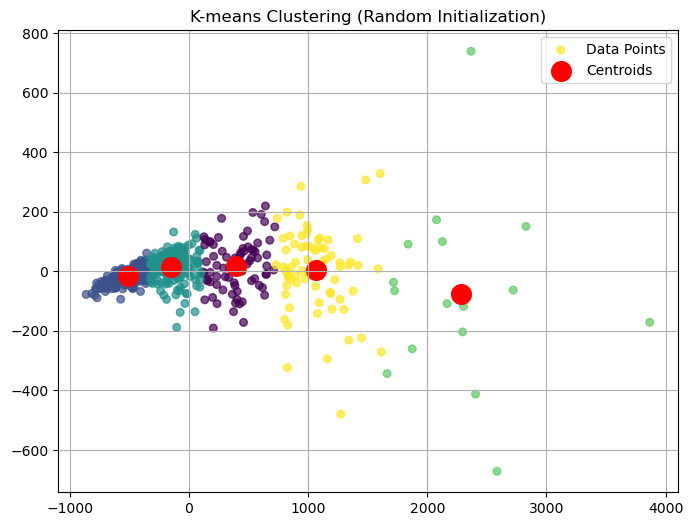

C:\Users\alexh\anaconda3\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


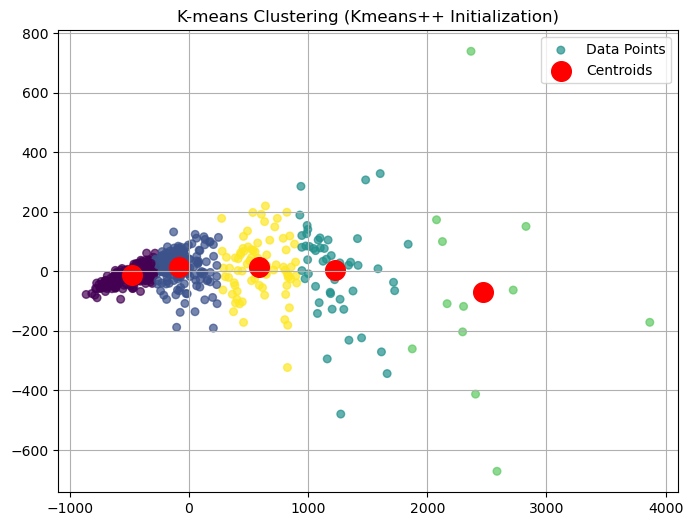

random: 2
random: 3
random: 4
random: 5
kmeans++: 2
kmeans++: 3
kmeans++: 4
kmeans++: 5


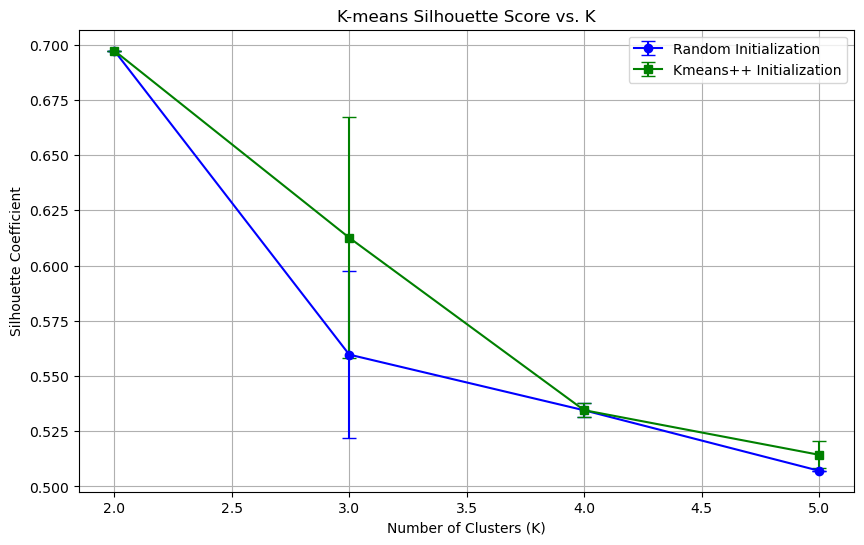

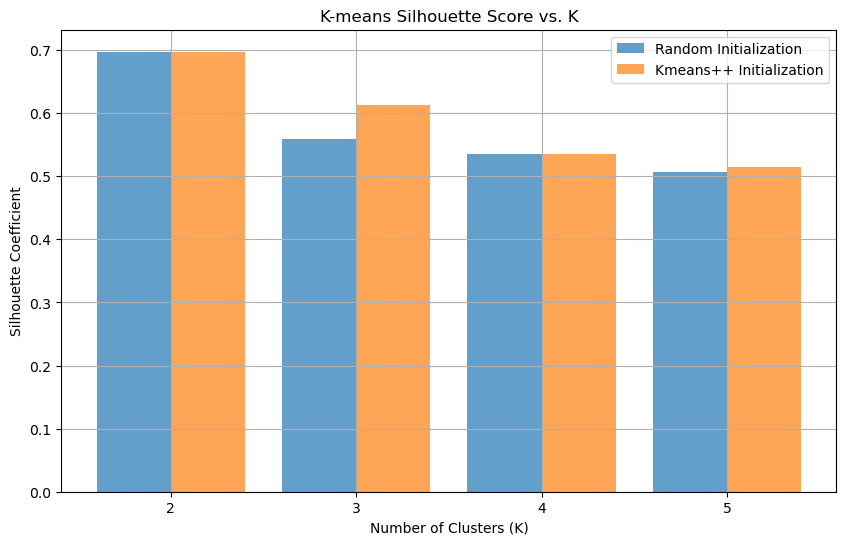

In [15]:
# [YOUR PLOTTING CODE HERE]

#evaluation of kmeans using silhouette scores
def evaluate_kmeans_fixedfinally(data, K_values, num_runs=10, init_methods=["random", "kmeans++"]):    
    results = {}
    for method in init_methods:
        results[method] = {"mean_silhouette": [], "std_silhouette": []}
        
    for init_method in init_methods:
        for K in K_values:
            print (f"{init_method}: {K}")
            silhouette_list = []

            for _ in range(num_runs):
                assignments, centroids, _ = kmeans_clustering(data, K, init_method=init_method)
                #adding silhouette score for current run to list, uses default sklearn library to calculate scores
                silhouette_list.append(silhouette_score(data, assignments))

            #adding mean and std values of silhouette scores to the results, which will be used for plotting
            results[init_method]["mean_silhouette"].append(np.mean(silhouette_list))
            results[init_method]["std_silhouette"].append(np.std(silhouette_list))

    return results

#plotting kmeans clusters (for testing and curiosity), takes as parameter the data (X), number of K values, and the initialization options
def plot_clusters(data, K_values, init_methods=["random", "kmeans++"]):
    
    for init_method in init_methods:
        assignments, centroids, _ = kmeans_clustering(data, K, init_method=init_method)

        #Reducing dimensions to 2D for visualization
        pca = PCA(n_components=2)
        data_reduced = pca.fit_transform(data)
        centroids_reduced = pca.transform(centroids)

        plt.figure(figsize=(8, 6))
        plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=assignments, cmap="viridis", s=30, alpha=0.7, label="Data Points")
        plt.scatter(centroids_reduced[:, 0], centroids_reduced[:, 1], c="red", s=200, label="Centroids")

        plt.title(f"K-means Clustering ({init_method.capitalize()} Initialization)")
        plt.xlabel("")
        plt.ylabel("")
        plt.legend()
        plt.grid(True)
        plt.show()




#takes 2 parameters, number of K values and the results from evaluate_kmeans_fixedfinally function
def plot_kmeans_silhouette(K_values, results):
    
    plt.figure(figsize=(10, 6))
    for method, color, marker in zip(results.keys(), ["blue", "green"], ["o", "s"]):
        mean_silhouette = results[method]["mean_silhouette"]
        std_silhouette = results[method]["std_silhouette"]
        plt.errorbar(
            K_values,
            mean_silhouette,
            yerr=std_silhouette,
            fmt=f"{marker}-",
            label=f"{method.capitalize()} Initialization",
            color=color,
            capsize=5,
        )

    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Coefficient")
    plt.title("K-means Silhouette Score vs. K")
    plt.legend()
    plt.grid(True)
    plt.show()

    
    plt.figure(figsize=(10, 6))
    bar_width = 0.4
    x = np.arange(len(K_values))
    for i, method in enumerate(results.keys()):
        mean_silhouette = results[method]["mean_silhouette"]
        plt.bar(
            x + i * bar_width,
            mean_silhouette,
            bar_width,
            label=f"{method.capitalize()} Initialization",
            alpha=0.7,
        )

    plt.xticks(x + bar_width / 2, K_values)
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Silhouette Coefficient")
    plt.title("K-means Silhouette Score vs. K")
    plt.legend()
    plt.grid(True)
    plt.show()



init_methods = ["random", "kmeans++"]
K_values = range(2, 6)
K = 5 



###FOR TESTING###
#plot_clusters(X_standardized, K, init_methods)
#plot_clusters(X_normalized, K, init_methods)
###FOR TESTING###

plot_clusters(X, K_values, init_methods)

###FOR TESTING###
#results = evaluate_kmeans_fixedfinally(X_standardized, K_values, num_runs=10, init_methods=init_methods)
#results = evaluate_kmeans_fixedfinally(X_normalized, K_values, num_runs=10, init_methods=init_methods)
###FOR TESTING###


results = evaluate_kmeans_fixedfinally(X, K_values, num_runs=10, init_methods=init_methods)
plot_kmeans_silhouette(K_values, results)

In [ ]:

X = np.array(X)
X_standardized = np.array(X_standardized)
X_normalized = np.array(X_normalized)

## Q2 - Density-based clustering with DBSCAN

For the function of DBScan, the logic was based on the explanation given in the slides for unsupervised learning. 

We begin with the DBScan function. 

1. Firstly, we implement a function that calculates the Euclidean distance from a point to every other point, and then returns the indices of the points that are within the particular epsilon or radius being used for that run. 


2. Secondly, we expand the cluster around the chosen core point. 
    
    a. To do so, we assign the current point to the current cluster, and then initialize a queue for the neighbors. 
    
    b. At first, those neighbors are considered core points but are not yet a part of the cluster
    
    c. However, we have to check whether they are part of the cluster or not. If not, since they are within the epsilon radius value, they are reclassified as part of the cluster
    
    d. Finally, we check if the current point has any neighbors that are density reachable (i.e, they're within the specified radius and minpts). If there are any such points, they are added to the queue
    
    

2. The next function simply focuses on plotting clusters for our DBScan implementation 
    
    

[-1 -1  1  2  1  2  1  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  2 -1
 -1 -1  2 -1  2  2  1 -1  2 -1  2  2  2  2  2  2  2  2  1  2  2  1  2  2
  2  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2  2  2 -1  2
 -1  2  2  2  2  1  1  2  2  2 -1 -1  2  1  2  1  2  2  2  2  2  2  2  1
  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  2  2  2  2
  2  1 -1  2  2  2  2  1  2  1  2  2  2  2  1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1 -1  2 -1  2  2  2
 -1  2  2  2  2  2  2  2  2  2  2  2 -1 -1  2  2  2  2  1  2  2  2  2  2
  2  2  2  2  2  2  1  2  2  2 -1 -1  2  2  2  2  2  2  1  2 -1 -1  2  2
  2  2 -1 -1  2  2  2  2  2  2  2  2  2  2  2  2  2  1  2  2 -1  1  2  2
  2  2  2  2 -1  2  2  2  2  2 -1  2 -1  2 -1  2 -1  2  2  2  1  2  2  2
 -1 -1  2  2  2  2  2  2 -1  2  2  2  2  2  2  2  1  2  1  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2 -1  2  1  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  1  2  2  2  1  2 -1  2  2  2  2  2

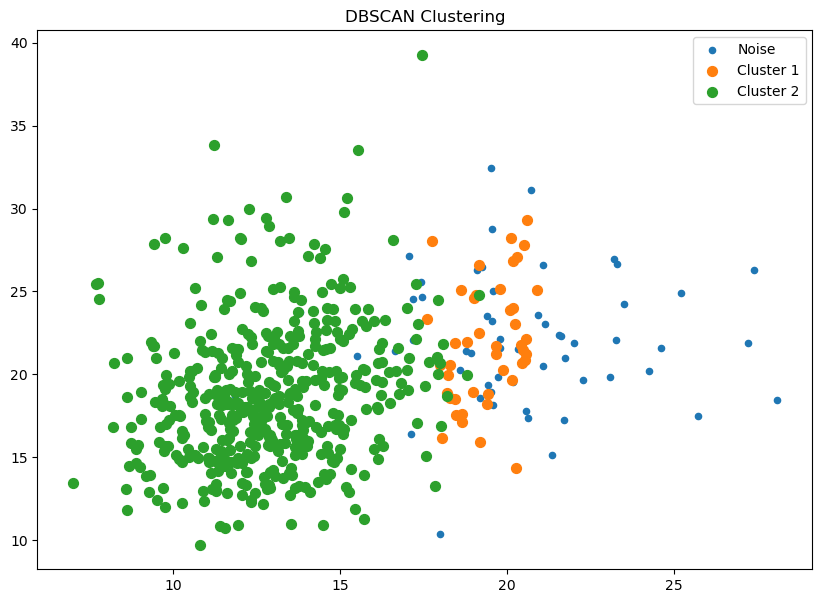

In [16]:
from collections import deque

def dbscan(X, eps, min_pts):
    X = np.array(X)
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)
    cluster_id = 0

    #return all neighbors withing eps of current point
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= eps)[0]

    #expand the cluster around the core point
    def expand_cluster(point_idx, neighbors):
        labels[point_idx] = cluster_id
        queue = deque(neighbors)

        while queue:
            current_point = queue.popleft()
            #if the current point is marked as noise, then assign it a cluster id
            if labels[current_point] == -1:
                labels[current_point] = cluster_id
            elif labels[current_point] != -1:
                continue
            
            #assign current point to cluster
            labels[current_point] = cluster_id
            new_neighbors = region_query(current_point)
            if len(new_neighbors) >= min_pts:
                queue.extend(new_neighbors)

    for point_idx in range(n_samples):
        if labels[point_idx] != -1:
            continue

        neighbors = region_query(point_idx)
        if len(neighbors) < min_pts:
            labels[point_idx] = -1
        else:
            cluster_id += 1
            expand_cluster(point_idx, neighbors)

    return labels

eps_test = 100
min_pts_test = 10
dbscan_labels = dbscan(X, eps=eps_test, min_pts=min_pts_test)
np.unique(dbscan_labels, return_counts=True)

print(dbscan_labels)


def plot_clusters(X, labels):
    X = np.array(X)
    unique_labels = np.unique(labels)

    plt.figure(figsize=(10, 7))
    for label in unique_labels:
        if label == -1:
            cluster_points = X[labels == label]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=20, label="Noise")
        else:
            cluster_points = X[labels == label]
            plt.scatter(cluster_points[:, 0], cluster_points[:, 1], s=50, label=f"Cluster {label}")
    
    plt.title("DBSCAN Clustering")
    plt.xlabel("")
    plt.ylabel("")
    plt.legend()
    plt.show()

plot_clusters(X, dbscan_labels)

1. The first function performs the actual evaluation, taking as parameters the datafeatures (X), the different K-values that will be tested, the number of runs, and the 2 initialization methods to test
    
    a. We create a dictionary called results, to hold the mean and standard deviation of silhouette scores for every K value and initialization method
    
    b. Within this function, for each K value, we create an empty array to hold the Silhouette scores
    
    c. Then we run the previous K-means clustering function 10 times (the number of runs given as a hyperparameter)
    
    d. Finally, for each run we append the average of and std values of the Silhouette score to the results dictionary
    
    
2. The second function deals with plotting the results of the average silhouette scores


Observations:
    We ran into some issues when working on this implementation. For instance, although at first we were able to show more than 1 cluster, we had not been able to replicate this . We tested this on normalized data, standardized data, and on the regular data. Our results appeared to be similar each time. We tested first on lower values of eps, which yielded a bunch of noise in the data, rather than clustering those points. When we tested with higher values of eps, we found that all points were once again clustered into 1 cluster, although the outliers were still classified as noise. Finally, the combination of eps and minpts that we tested which worked the best was having an eps value of 100 and minpts value of 10, yielding 2 relatively distinct clusters, although there was still a considerable amount of noise. 
    Regarding the Silhouette scores, we chose to use values of '100' and '150' for eps, and the given values of minpts from the assignment instructions. While the '150' eps radius yielded an average Silhouette coefficient close to 0.7 each time, the '100' eps radius varied between 0.5 and 0.7. This indicated that while the clustering was strong, it was not as strong as a clustering of 1, similar to our results for K-means clustering. 

Since we did not normalize the data for K-means clustering, we also chose not to normalize it for our tests on DBScan, which is one of the reasons we used considerably higher eps values. 

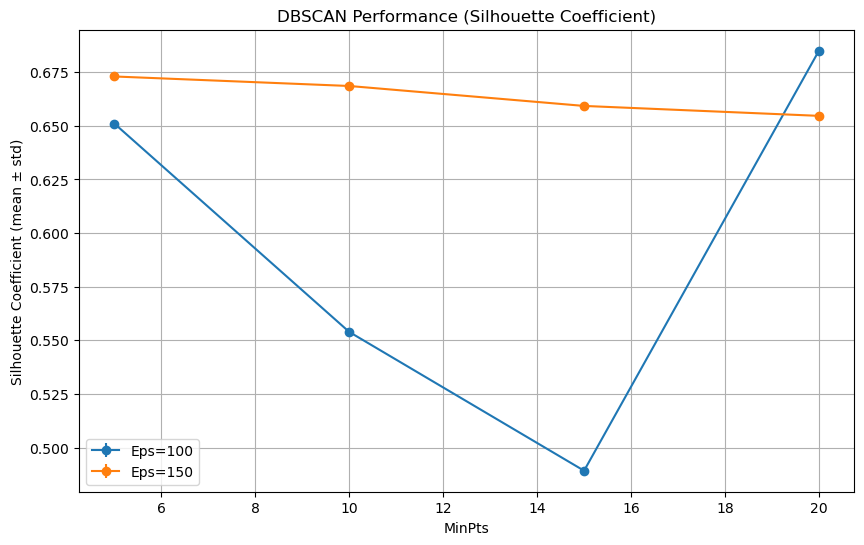

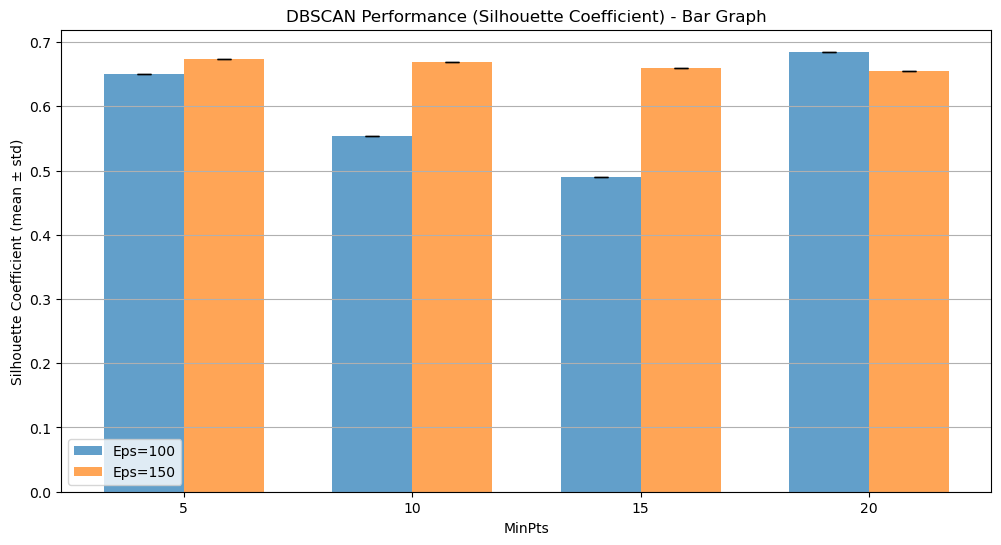

In [17]:
def evaluate_dbscan(X, eps_values, min_pts_values, n_runs=10):
    results = {eps: [] for eps in eps_values}
    
    for eps in eps_values:
        for min_pts in min_pts_values:
            silhouette_scores = []
            for _ in range(n_runs):
                labels = dbscan(X, eps=eps, min_pts=min_pts)
                if len(np.unique(labels)) > 1:
                    #calculate silhouette score for every run of DBScan, using default sklearn implementation
                    score = silhouette_score(X, labels)
                    silhouette_scores.append(score)
            
            #Calculate mean and std of Silhouette scores
            mean_score = np.mean(silhouette_scores)
            std_score = np.std(silhouette_scores)
            results[eps].append((min_pts, mean_score, std_score))
    
    return results


#takes as parameters the results from DBScan evaluation, as well as array of min_pts
def plot_results(results, min_pts_values):
    plt.figure(figsize=(10, 6))
    for eps, metrics in results.items():
        means = []
        stds = []

        for m in metrics:
            means.append(m[1])
            stds.append(m[2])
            
        plt.errorbar(min_pts_values, means, yerr=stds, label=f"Eps={eps}", fmt='-o')

    plt.title("DBSCAN Performance (Silhouette Coefficient)")
    plt.xlabel("MinPts")
    plt.ylabel("Silhouette Coefficient (mean ± std)")
    plt.legend()
    plt.grid()
    plt.show()


    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    x = np.arange(len(min_pts_values))

    offsets = np.linspace(-bar_width / 2, bar_width / 2, len(results))

    for idx, item in enumerate(results.items()):
        eps, metrics = item
        means = []
        stds = []
        for m in metrics:
            means.append(m[1])
            stds.append(m[2])
        plt.bar(
            x + offsets[idx],
            means,
            bar_width,
            yerr=stds,
            label=f"Eps={eps}",
            capsize=5,
            alpha=0.7
        )

    plt.xticks(x, min_pts_values)
    plt.title("DBSCAN Performance (Silhouette Coefficient) - Bar Graph")
    plt.xlabel("MinPts")
    plt.ylabel("Silhouette Coefficient (mean ± std)")
    plt.legend()
    plt.grid(axis='y')
    plt.show()

#parameters for eps and min_pts, provided by instructions
eps_values = [100, 150]
min_pts_values = [5, 10, 15, 20]

results = evaluate_dbscan(X, eps_values, min_pts_values, n_runs=10)

plot_results(results, min_pts_values)

## Q3 - Graph-based clustering with Spectral Clustering

**Function compute_similarity_matrix**
This function calculates a similarity matrix S based on a given dataset X and a bandwidth parameter sigma.

* `Calculate pairwise distances:`
For each pair of data points X[i] and X[j], the Euclidean distance is computed using np.linalg.norm.

* `Compute similarity scores:`
The pairwise distances are transformed into similarity scores using a Gaussian kernel with bandwidth sigma. This kernel assigns higher similarity scores to closer data points.

**Function `unnormalized_spectral_clustering Function**
This function performs unnormalized spectral clustering on a similarity matrix S to partition the data into k clusters.

* `Compute Degree Matrix:`
The degree matrix D is a diagonal matrix where the diagonal entries are the row sums of the similarity matrix S.
* `Compute Laplacian Matrix:` The Laplacian matrix L is calculated as L = D - S.
* `Eigenvalue Decomposition:` The eigenvalues and eigenvectors of the Laplacian matrix are computed.
* `Select Top Eigenvectors:` The eigenvectors corresponding to the k smallest eigenvalues are selected. These eigenvectors represent the low-dimensional embedding of the data points.
Clustering: The k-means algorithm is applied to the low-dimensional embedding to cluster the data points.

In [ ]:
# [YOUR IMPLEMENTATION CODE HERE]



# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)
#X_df = breast_cancer_wisconsin_diagnostic.data.features
X_df = X_normalized
y_df = breast_cancer_wisconsin_diagnostic.data.targets

def compute_similarity_matrix(X, sigma):
    n = X.shape[0]
    S = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            dist = np.linalg.norm(X[i] - X[j])
            S[i, j] = np.exp(-dist**2 / (2 * sigma**2))
    return S




def unnormalized_spectral_clustering(S, k):
    # Compute Degree Matrix D
    D = np.diag(S.sum(axis=1)) 
    # Compute Laplacian Matrix L
    L = D - S
    # Compute the first k eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    # the eigenvectors corresponding to the k smallest eigenvalues
    X = eigenvectors[:, :k]
    # Cluster the data points represented by rows of X
    labels,cent,_ = kmeans_clustering(X, k, max_iter=100, tol=1e-4, init_method="kmeans++")
    #kmeans = KMeans(n_clusters=k)
    #labels = kmeans.fit_predict(X)
    return labels



In [ ]:
# [YOUR PLOTTING CODE HERE]

## Q4 - Anomaly detection with the Isolation Forest

In [ ]:
# [YOUR IMPLEMENTATION CODE HERE]

In [ ]:
# [YOUR PLOTTING CODE HERE]

# References / Disclosures

[Add your references / disclosures for your implementations here]
